In [2]:
import random

# StringIO behaves like a file object 
from io import StringIO 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import load_boston
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline 

In [3]:
class CqkProblem:
    def __init__(self, r, n, d, a, b, low, up):
        self.n = n
        self.r = r
        self.d = list(d)
        self.a = list(a)
        self.b = list(b)
        self.low = list(low)
        self.up = list(up)

In [4]:
def generate_cqk_problem(n):
    d = []
    low = []
    up = []
    b = []
    a = []
    temp = 0
    lb = 0.0
    ub = 0.0
    lower = 10
    upper = 25
    r = 0

    for i in range(n):
        
        b.append(10 + 14*random.random())
        low.append(1 + 14*random.random())
        up.append(1 + 14*random.random())
        if low[i] > up[i]:
            temp = low[i]
            low[i] = up[i]
            up[i] = temp
        
        lb = lb + b[i]*low[i];
        ub = ub + b[i]*up[i];
        
        #Uncorrelated
        d.append(random.randint(10,25))
        a.append(random.randint(10,25))
        
    r = lb + (ub - lb)*0.7;
    
    return CqkProblem( r, n, d, a, b, low, up)

In [5]:

def initial_lambda(p, lamb):
    s0=0.0
    q0=0.0
    slopes = []
    for i in range(p.n):
        slopes.append((p.b[i]/p.d[i])*p.b[i])
        s0 = s0 + (p.a[i] * p.b[i]) / p.d[i]
        q0 = q0 + (p.b[i] * p.b[i]) / p.d[i]
    lamb = (p.r-s0)/q0
    return lamb, slopes

In [6]:
def phi_lambda(p,lamb,phi,deriv,slopes,r):
    deriv = 0.0
    phi = r * -1
    x = []
    
    for i in range(p.n):
        
        x.append( (p.b[i] * lamb + p.a[i])/p.d[i])

        if x[i] < p.low[i]:
            x[i] = p.low[i]
        elif x[i] > p.up[i]:
            x[i] = p.up[i]
        else:
            deriv = deriv + slopes[i];
        phi = phi + p.b[i] * x[i];
    return deriv, phi, x

In [40]:
MAX_IT = 20
INFINITO_NEGATIVO = -999999999;
INFINITO_POSITIVO = 999999999;

def newton(p):
    lambs = [] 
    phi = 0
    lamb = 0
    alfa = INFINITO_NEGATIVO;
    beta = INFINITO_POSITIVO;
    phi_alfa = 0.0;
    phi_beta = 0.0;
    deriv = 0
    x = []
    r = p.r
    
    lamb, slopes = initial_lambda(p,lamb)
    deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
    lambs.append(lamb)
    it = 1
#     print(it, deriv, phi,lamb)
    while phi != 0.0 and it <= MAX_IT:
        if phi > 0:
#             print("positivo")
            beta = lamb
            lambda_n = 0.0
            if deriv > 0.0:
                
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                if lambda_n > alfa:
                    lamb = lambda_n
                else:
                    print("aqui")
                    phi_beta = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_left(p,lamb);
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
                
        else:
#             print("negativo")
            alfa = lamb;
            lambda_n = 0.0;

            if deriv > 0.0:
                lambda_n = lamb - (phi/deriv)
                if abs(lambda_n - lamb) <= 0.00000000001:
                    phi = 0.0
                    break
                
                if lambda_n < beta:
                    lamb = lambda_n
                else:
                    print("aqui")
                    phi_alfa = phi;
#                     lamb = secant(p,x,alfa,beta,phi_alfa,phi_beta,r);
#             if deriv == 0.0:
#                 lamb = breakpoint_to_the_right(p,lamb)
#                 if lamb <= INFINITO_NEGATIVO or lamb >= INFINITO_POSITIVO:
#                     break
        
        
        deriv, phi, x = phi_lambda(p,lamb,phi,deriv,slopes,r)
        it = it + 1
        lambs.append(lamb)
        
    if phi == 0.0:
        return it, lambs
    elif alfa == beta:
        return -1
    else:
        return -2

In [124]:
lista = []
for i in range(1000):
    n = 100
    p = generate_cqk_problem(n)
    p = generate_cqk_problem(n)
    it, lambs = newton(p)
    soma_a = 0
    soma_b = 0
    soma_low = 0
    soma_d = 0
    soma_up = 0
    for i in range(n):
        soma_a += p.a[i]
        soma_b += p.b[i]
        soma_low += p.low[i]
        soma_d += p.d[i]
        soma_up += p.up[i]
    
#     soma_a = soma_a/n
#     soma_b = soma_b/n
#     soma_low = soma_low/n
#     soma_d = soma_d/n
#     soma_up = soma_up/n
    
    l_rs = [soma_a, soma_b, soma_low, soma_up, soma_d, p.r, lambs[0], lambs[-1]]
    lista.append(l_rs)

In [125]:
np.savetxt('instance_test.txt', lista, delimiter = ' ',newline='\n', fmt="%f")

In [126]:
c = ''
with open("instance_test.txt", "r") as fd:
    c = StringIO(fd.read())

In [127]:
d = c.read()
c = StringIO(d) 
d = np.loadtxt(c) 
feature_names = ['a', 'b', 'low', 'up', 'd', 'r', 'lamb_initial', 'target']

In [128]:
knapsack = {"data":d, "feature_names": feature_names}
dataset = pd.DataFrame(knapsack['data'], columns = knapsack['feature_names'])

In [129]:
# Gerando número de observações e variáveis
observations = len(dataset)
variables = dataset.columns[:-1]

In [130]:
# Coletando x e y
X = dataset.iloc[:,:-1]
y = dataset['target'].values

In [131]:
X.head()

,a,b,low,up,d,r,lamb_initial
0,1802.0,1765.190341,638.291066,1046.537037,1715.0,16434.585844,6.852078
1,1749.0,1717.982193,550.920221,1016.201652,1753.0,15010.979282,6.797498
2,1724.0,1724.466043,520.424476,1072.263565,1791.0,15651.218052,7.300037
3,1704.0,1691.842244,565.500089,1019.704943,1775.0,14818.025110,7.098448
4,1675.0,1712.837116,582.703217,1008.118080,1720.0,15223.516548,6.962020


In [132]:
y

array([ 8.72616 ,  9.029261,  8.847333,  8.510457,  8.710863,  7.964713,
        8.619453,  8.429237,  8.968565,  8.344798,  8.967029,  9.347839,
        9.007184,  9.626862,  7.923554,  8.781274,  9.358153,  9.908854,
        9.081039,  8.7028  ,  9.178844,  8.467576,  8.599293,  8.114401,
        9.597447,  8.843878,  8.54187 ,  9.515712,  8.473123,  9.500676,
        9.4108  ,  9.049805,  9.17708 , 10.006508,  7.823682,  8.558032,
        9.699997,  8.655337,  8.773047,  8.452175,  8.278395,  8.175354,
        8.159699,  8.551207,  9.479596,  9.050189,  9.803157,  8.7924  ,
        8.503985,  9.092497,  9.798849,  9.173162,  8.837881,  8.262292,
        8.607777,  8.580854,  7.335161,  8.743305,  9.105424,  8.667079,
        8.265931,  8.992558,  7.977309,  8.940771,  9.39441 ,  8.973097,
        7.958862,  8.824726, 10.605731,  8.299727,  8.645402,  9.286368,
        9.198529,  8.703465,  8.259708,  9.776429,  8.965483,  8.840923,
        7.731855,  9.427795,  9.737713,  8.366527, 

## Usando Múltiplos Atributos com StatsModels

In [133]:
Xc = sm.add_constant(X)
modelo_v1 = sm.OLS(y, Xc)
modelo_v2 = modelo_v1.fit()

In [134]:
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     159.5
Date:                Thu, 18 Jun 2020   Prob (F-statistic):          1.20e-157
Time:                        19:33:03   Log-Likelihood:                -437.83
No. Observations:                1000   AIC:                             891.7
Df Residuals:                     992   BIC:                             930.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.3153      1.853     -2.868      0.004      -8.952      -1.679
a             6.831e-05      0.000      0.263      0.792      -0.000       0.001
b                0.0002      0.001      0.143      0.886      -0.002       0.003
low              0.0043      0.001      6.477      0.000       0.003       0.006
up               0.0074      0.001      5.648      0.000       0.005       0.010
d                0.0042      0.001      7.626      0.000       0.003       0.005
r               -0.0004      0.000     -3.645      0.000      -0.001      -0.000
lamb_initial     0.3692      0.099      3.732      0.000       0.175       0.563
==============================================================================
Omnibus:                        0.491   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.536
Skew:                           0.052   Prob(JB):                        0.765
Kurtosis:                       2.953   Cond. No.                     2.42e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Matriz de Correlação

In [106]:
# Gerando a matriz
X = dataset.iloc[:,:-1]
matriz_corr = X.corr()
print (matriz_corr)

                     a         b       low        up         d         r  \
a             1.000000 -0.308087  0.092505 -0.029564  0.033896 -0.128303   
b            -0.308087  1.000000 -0.007679 -0.046633 -0.152087  0.589481   
low           0.092505 -0.007679  1.000000  0.390364 -0.139425  0.542334   
up           -0.029564 -0.046633  0.390364  1.000000  0.013560  0.697243   
d             0.033896 -0.152087 -0.139425  0.013560  1.000000 -0.126205   
r            -0.128303  0.589481  0.542334  0.697243 -0.126205  1.000000   
lamb_initial  0.098673 -0.502399  0.324362  0.585013  0.599896  0.176511   

              lamb_initial  
a                 0.098673  
b                -0.502399  
low               0.324362  
up                0.585013  
d                 0.599896  
r                 0.176511  
lamb_initial      1.000000  


In [107]:
# Criando um Correlation Plot
def visualize_correlation_matrix(data, hurdle = 0.0):
    R = np.corrcoef(data, rowvar = 0)
    R[np.where(np.abs(R) < hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap = mpl.cm.coolwarm, alpha = 0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor = False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor = False)
    heatmap.axes.set_xticklabels(variables, minor = False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(variables, minor = False)
    plt.tick_params(axis = 'both', which = 'both', bottom = 'off', top = 'off', left = 'off', right = 'off') 
    plt.colorbar()
    plt.show()

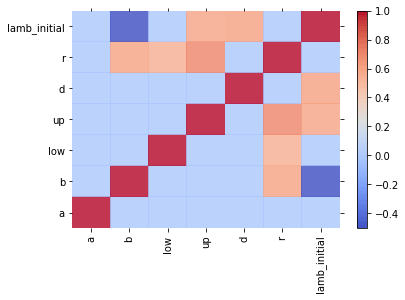

In [108]:
# Visualizando o Plot
visualize_correlation_matrix(X, hurdle = 0.5)

## Avaliando a Multicolinearidade

## Gradiente Descendente

In [109]:
# Gerando os dados
observations = len(dataset)
variables = dataset.columns

In [110]:
# Aplicando Padronização
standardization = StandardScaler()
Xst = standardization.fit_transform(X)
original_means = standardization.mean_
originanal_stds = standardization.scale_

In [111]:
# Gerando X e Y
Xst = np.column_stack((Xst,np.ones(observations)))
y  = dataset['target'].values

In [112]:
import random
import numpy as np

def random_w( p ):
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(X,w):
    return np.dot(X,w)

def loss(X,w,y):
    return hypothesis(X,w) - y

def squared_loss(X,w,y):
    return loss(X,w,y)**2

def gradient(X,w,y):
    gradients = list()
    n = float(len( y ))
    for j in range(len(w)):
        gradients.append(np.sum(loss(X,w,y) * X[:,j]) / n)
    return gradients

def update(X,w,y, alpha = 0.01):
    return [t - alpha*g for t, g in zip(w, gradient(X,w,y))]

def optimize(X,y, alpha = 0.01, eta = 10**-12, iterations = 1000):
    w = random_w(X.shape[1])
    path = list()
    for k in range(iterations):
        SSL = np.sum(squared_loss(X,w,y))
        new_w = update(X,w,y, alpha = alpha)
        new_SSL = np.sum(squared_loss(X,new_w,y))
        w = new_w
        if k>=5 and (new_SSL - SSL <= eta and new_SSL - SSL >= -eta):
            path.append(new_SSL)
            return w, path
        if k % (iterations / 20) == 0:
            path.append(new_SSL)
    return w, path   

In [113]:
# Imprimindo o resultado                           
alpha = 0.01
w, path = optimize(Xst, y, alpha, eta = 10**-12, iterations = 20000)
print ("Coeficientes finais padronizados: " + ', '.join(map(lambda x: "%0.4f" % x, w)))            

Coeficientes finais padronizados: -0.0163, -0.1181, 0.1445, 0.2459, 0.2504, -0.1662, -0.0377, 8.8577


In [114]:
# Desfazendo a Padronização
unstandardized_betas = w[:-1] / originanal_stds
unstandardized_bias  = w[-1]-np.sum((original_means / originanal_stds) * w[:-1])

In [115]:
# Imprimindo o resultado
print ('%8s: %8.4f' % ('bias', unstandardized_bias))
for beta,varname in zip(unstandardized_betas, variables):
    print ('%8s: %8.4f' % (varname, beta))

    bias:  -1.2250
       a:  -0.0004
       b:  -0.0031
     low:   0.0043
      up:   0.0087
       d:   0.0055
       r:  -0.0003
lamb_initial:  -0.0938


## Importância dos Atributos


In [116]:
# Criando um modelo
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [117]:
modelo.fit(X,y)
for coef, var in sorted(zip(map(abs, modelo.coef_), dataset.columns[:-1]), reverse = True):
    print ("%6.3f %s" % (coef,var))

 0.113 lamb_initial
 0.008 up
 0.006 d
 0.004 low
 0.004 b
 0.000 a
 0.000 r


In [118]:
standardization = StandardScaler()
Stand_coef_linear_reg = make_pipeline(standardization, modelo)

In [119]:
Stand_coef_linear_reg.fit(X,y)
for coef, var in sorted(zip(map(abs, Stand_coef_linear_reg.steps[1][1].coef_), dataset.columns[:-1]), reverse = True):
    print ("%6.3f %s" % (coef,var))

 0.255 d
 0.237 up
 0.145 r
 0.140 low
 0.135 b
 0.046 lamb_initial
 0.018 a


### Usando o R Squared


In [120]:
modelo = linear_model.LinearRegression(normalize = False, fit_intercept = True)

In [121]:
def r2_est(X,y):
    return r2_score(y, modelo.fit(X,y).predict(X))

In [122]:
print ('Baseline R2: %0.3f' %  r2_est(X,y))

Baseline R2: 0.544


In [123]:
# Gera o impacto de cada atributo no R2
r2_impact = list()
for j in range(X.shape[1]):
    selection = [i for i in range(X.shape[1]) if i!=j]
    r2_impact.append(((r2_est(X,y) - r2_est(X.values[:,selection],y)), dataset.columns[j]))
    
for imp, varname in sorted(r2_impact, reverse = True):
    print ('%6.3f %s' %  (imp, varname))

 0.054 d
 0.022 low
 0.021 up
 0.003 b
 0.003 r
 0.001 a
 0.001 lamb_initial
